"""
Business Understanding
Why Shipment Delays Are a Problem - Shipment delays are a critical issue in logistics operations because they directly affect customer satisfaction, 
operational efficiency, and overall business profitability. Late deliveries lead to dissatisfied customers, increased complaints, 
and potential loss of long-term contracts. From an operational perspective, delays disrupt delivery schedules, create congestion across 
the logistics network, and increase costs due to penalties, overtime labor, and inefficient resource utilization. As shipment volumes grow, 
unmanaged delays can significantly reduce the reliability and competitiveness of the logistics organization.

Business Decisions That Benefit from Early Delay Prediction - Early prediction of shipment delays enables management to take proactive, data-driven decisions rather than reactive actions. 
By identifying high-risk shipments in advance, operations teams can prioritize monitoring, reassign carriers, adjust delivery schedules, 
or allocate additional resources to prevent delays. Predictive insights also help in route planning, carrier performance management, 
customer communication, and capacity planning. Overall, early delay prediction supports better service-level adherence and cost control.

Target Variable
The target variable for this analysis is Shipment Delay Status, classified as:
Delayed (1) – Shipment delivered later than the scheduled delivery date
On-Time (0) – Shipment delivered within the planned delivery timeframe
This binary classification makes the problem suitable for supervised machine learning models.
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_excel("Shipment_Basic.xlsx")
df.head()

,Shipment_ID,Origin,Destination,Distance_km,Transport_Mode,Carrier,Shipment_Weight,Shipment_Value,Day_of_Week,Month,Holiday_Flag,Delivered_On_Time
0,1,Bangalore,Mumbai,811,Road,Carrier_A,1163,221296,2,4,0,1
1,2,Hyderabad,Hyderabad,239,Road,Carrier_B,6759,453856,3,3,1,1
2,3,Chennai,Bangalore,760,Road,Carrier_D,3848,125155,1,7,0,1
3,4,Hyderabad,Bangalore,1557,Rail,Carrier_A,4645,140560,5,9,0,0
4,5,Hyderabad,Hyderabad,1806,Air,Carrier_D,2832,170620,5,4,0,0


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Shipment_ID        5000 non-null   int64
 1   Origin             5000 non-null   str  
 2   Destination        5000 non-null   str  
 3   Distance_km        5000 non-null   int64
 4   Transport_Mode     5000 non-null   str  
 5   Carrier            5000 non-null   str  
 6   Shipment_Weight    5000 non-null   int64
 7   Shipment_Value     5000 non-null   int64
 8   Day_of_Week        5000 non-null   int64
 9   Month              5000 non-null   int64
 10  Holiday_Flag       5000 non-null   int64
 11  Delivered_On_Time  5000 non-null   int64
dtypes: int64(8), str(4)
memory usage: 468.9 KB


In [4]:
df.describe()

,Shipment_ID,Distance_km,Shipment_Weight,Shipment_Value,Day_of_Week,Month,Holiday_Flag,Delivered_On_Time
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,1035.609400,5065.287000,252597.967600,4.044200,6.581000,0.144000,0.622800
std,1443.520003,557.789962,2848.575542,140571.877951,1.994352,3.403727,0.351125,0.484734
min,1.000000,50.000000,100.000000,10059.000000,1.000000,1.000000,0.000000,0.000000
25%,1250.750000,563.000000,2613.000000,132210.000000,2.000000,4.000000,0.000000,0.000000
50%,2500.500000,1040.000000,5056.500000,249448.500000,4.000000,7.000000,0.000000,1.000000
75%,3750.250000,1521.000000,7559.250000,373766.250000,6.000000,10.000000,0.000000,1.000000
max,5000.000000,1999.000000,9999.000000,499905.000000,7.000000,12.000000,1.000000,1.000000


In [5]:
df.isnull().sum()

Shipment_ID          0
Origin               0
Destination          0
Distance_km          0
Transport_Mode       0
Carrier              0
Shipment_Weight      0
Shipment_Value       0
Day_of_Week          0
Month                0
Holiday_Flag         0
Delivered_On_Time    0
dtype: int64

In [6]:
# Basic Data Understanding
print("\nColumns info:")
print(df.info())


Columns info:
<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Shipment_ID        5000 non-null   int64
 1   Origin             5000 non-null   str  
 2   Destination        5000 non-null   str  
 3   Distance_km        5000 non-null   int64
 4   Transport_Mode     5000 non-null   str  
 5   Carrier            5000 non-null   str  
 6   Shipment_Weight    5000 non-null   int64
 7   Shipment_Value     5000 non-null   int64
 8   Day_of_Week        5000 non-null   int64
 9   Month              5000 non-null   int64
 10  Holiday_Flag       5000 non-null   int64
 11  Delivered_On_Time  5000 non-null   int64
dtypes: int64(8), str(4)
memory usage: 468.9 KB
None


In [7]:
# Weekend Flag
df['Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x in [6,7] else 0)

# Distance Bucket
df['Distance_Bucket'] = pd.cut(
    df['Distance_km'],
    bins=[0,300,800,np.inf],
    labels=['Short','Medium','Long']
)

In [8]:
# Encode categorical variables
categorical_cols = ['Transport_Mode','Carrier','Distance_Bucket']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [9]:
# Exploratory Data Analysis 

# % On-Time vs Delayed
on_time_pct = df['Delivered_On_Time'].value_counts(normalize=True)*100
print("\nOn-Time vs Delayed (%):")
print(on_time_pct)


On-Time vs Delayed (%):
Delivered_On_Time
1    62.28
0    37.72
Name: proportion, dtype: float64


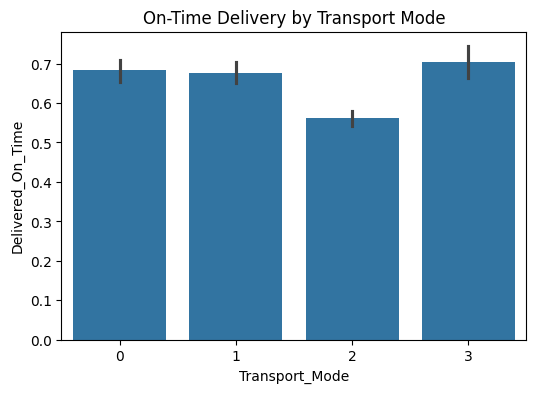

In [10]:
# Transport Mode vs Delay
plt.figure(figsize=(6,4))
sns.barplot(x='Transport_Mode', y='Delivered_On_Time', data=df)
plt.title("On-Time Delivery by Transport Mode")
plt.show()

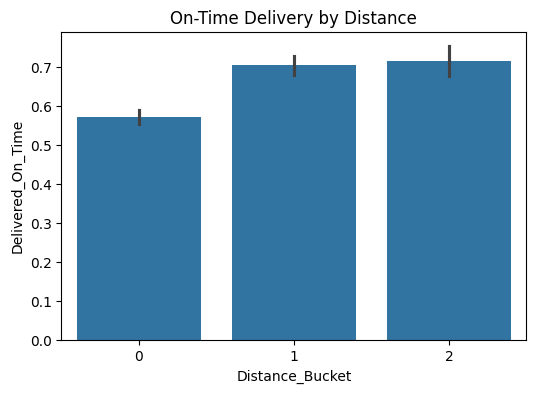

In [11]:
# Distance vs Delay
plt.figure(figsize=(6,4))
sns.barplot(x='Distance_Bucket', y='Delivered_On_Time', data=df)
plt.title("On-Time Delivery by Distance")
plt.show()

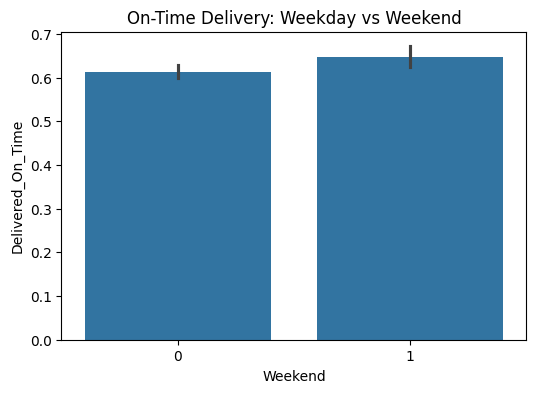

In [12]:
# Weekend vs Delay
plt.figure(figsize=(6,4))
sns.barplot(x='Weekend', y='Delivered_On_Time', data=df)
plt.title("On-Time Delivery: Weekday vs Weekend")
plt.show()

In [13]:
# Prepare Data for Modeling

# List all categorical columns to encode
categorical_cols = ['Origin','Destination','Transport_Mode','Carrier','Distance_Bucket']

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [14]:
# Now prepare features and target
X = df.drop(columns=['Shipment_ID','Delivered_On_Time'])
y = df['Delivered_On_Time']

In [15]:
# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [16]:
# Build Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [17]:
# Build Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [18]:
# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix
dt_preds = dt_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

In [19]:
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Decision Tree Accuracy: 0.6248
Random Forest Accuracy: 0.628



Top Drivers of Shipment Delay:
           Feature  Importance
2      Distance_km    0.190622
6   Shipment_Value    0.175162
5  Shipment_Weight    0.169934
8            Month    0.100840
7      Day_of_Week    0.070649
1      Destination    0.066505
0           Origin    0.065443
4          Carrier    0.056797
3   Transport_Mode    0.045126
9     Holiday_Flag    0.024908


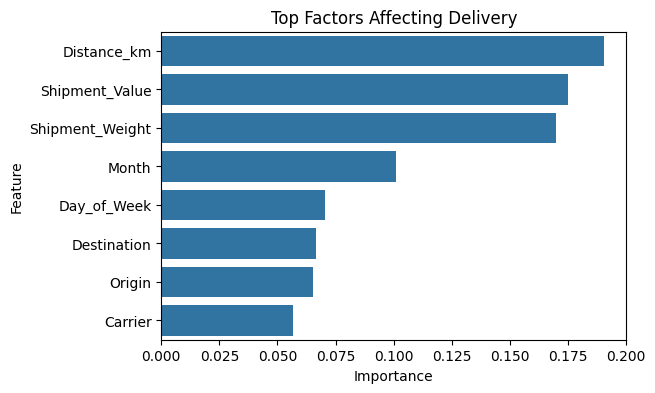

In [20]:
# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Drivers of Shipment Delay:")
print(feature_importance.head(10))

plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(8))
plt.title("Top Factors Affecting Delivery")
plt.show()

In [21]:
# Generate Risk Predictions for Each Shipment
df['Delay_Risk_Prediction'] = rf_model.predict(X)
df[['Shipment_ID','Delivered_On_Time','Delay_Risk_Prediction']].head()

,Shipment_ID,Delivered_On_Time,Delay_Risk_Prediction
0,1,1,1
1,2,1,1
2,3,1,1
3,4,0,0
4,5,0,0


In [23]:
# Explainability – Key Delay Drivers

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.head(10)


,Feature,Importance
2,Distance_km,0.190622
6,Shipment_Value,0.175162
5,Shipment_Weight,0.169934
8,Month,0.100840
7,Day_of_Week,0.070649
1,Destination,0.066505
0,Origin,0.065443
4,Carrier,0.056797
3,Transport_Mode,0.045126
9,Holiday_Flag,0.024908


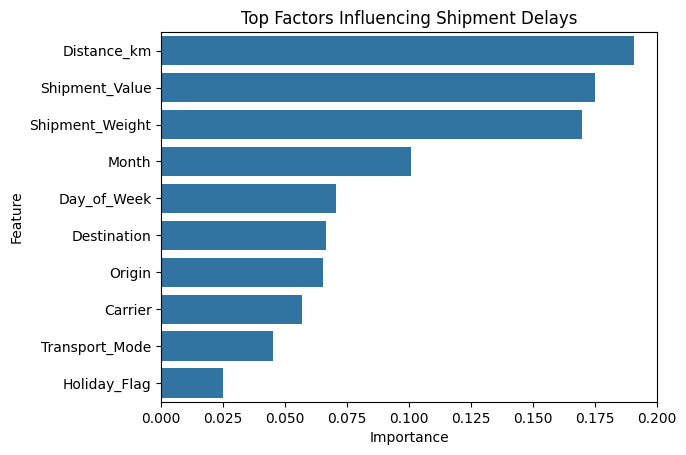

In [24]:
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top Factors Influencing Shipment Delays")
plt.show()

#Decision Support & Recommendations
"""
Key Recommendations:

1. Prioritize long-distance and weekend shipments for proactive monitoring.
2. Assign experienced carriers to high-risk transport modes.
3. Introduce buffer times for routes with historically high delays.
4. Improve scheduling and staffing during weekends.
5. Use delay prediction output to trigger early alerts to operations teams.
"""